# Predciting Full Season Batting Average using March and April Batting Data

The following code uses an XGBRegressor model to predict full season batting averages using only data from March and April of the same season. The model was built in three steps:

Step 1 - Build a model to predict March/April batting averages using other March/April statistics

Step 2 - Predict full season values for the statistics used in the model using weighted averages and an assumption of regressing to the mean.

Step 3 - Predict final batting averages using the model built in Step 1 and statistics from Step 2.

# Setup Code

Imports any needed packages and the data provided.

In [69]:
# Load packages
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns


# Import Data
data_dir = '/Users/Koby/PycharmProjects/PhilliesBAModel/Input/'
df_data = pd.read_csv(data_dir + 'batting.csv')

# Step 1: Building the Initial Model

In order to start building an initial model I needed to break the data into features and an outcome. For the first model the March/April Batting Averages were the outcome and any other field in the csv file could be a feature.

Some columns provided don't make sense to use for batting average predicitions like hits, runs, RBIs, and stolen bases so I excluded them from the features.

In [82]:
# Get features for initial model training and batting averages from first month of season
X = df_data[['MarApr_BB%', 'MarApr_K%', 'MarApr_ISO', 'MarApr_BABIP', 'MarApr_OBP',
             'MarApr_LD%', 'MarApr_GB%', 'MarApr_FB%', 'MarApr_IFFB%', 'MarApr_HR/FB', 'MarApr_O-Swing%',
             'MarApr_Z-Swing%', 'MarApr_Swing%', 'MarApr_O-Contact%', 'MarApr_Z-Contact%', 'MarApr_Contact%']].copy()
y = df_data['MarApr_AVG'].copy()

XGBoost is a package that builds ensemble models with high speed and performance. I chose to use this package for my model because I have used it in the past and find it outperforms other techniques like linear regression or regression trees and is easier to tune.

Once the variables were separated I built an initial XGBRegression model. I used basic parameters as this model is not going to be the final model used for predicitions.

In [83]:
# Trains an initial model using most of the features given in the dataset.
XGB_model1 = XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=3, subsample=0.8)
clf_original = XGB_model1.fit(X,y)

[20:38:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


I used cross-validation to train and test the model. Cross-validitation was prefered because it gives a better idea of model performance than train-test splits and allows all data to be used since there wasn't a large volume of data.

I used Mean Average Error to evaluate model performance. MAE was chosen because it penalizes each error equally. 
This is ideal because a single player who significantly outperforms/underperforms expectations in a year is not uncommon but would make a model that otherwise predicts batting average well look poor. Additionally, MAE is easy to use to explain the model's performance. A MAE of 0.010 means each predicition will be 0.010 off on average. 

In [109]:
# Evaluate using cross validation and MAE scoring.
CV_score = cross_val_score(XGB_model1, X, y, scoring='neg_mean_absolute_error')
scr = round(np.mean(CV_score), 4)
print("MAE for All Features: ", scr)

[21:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE for All Features:  -0.0213


It is easier to understand a model with less features and usually there is a threshold when features are not adding much predictive value. I printed the feature importances from the initial model to choose which features I would use for the final model.

In [85]:
# Print feature importances to ID top features for final model.
print(pd.DataFrame({'Variable':X.columns,
                    'Importance':XGB_model1.feature_importances_}).sort_values('Importance', ascending=False))

             Variable  Importance
4          MarApr_OBP    0.414666
3        MarApr_BABIP    0.357582
1           MarApr_K%    0.064168
2          MarApr_ISO    0.056116
0          MarApr_BB%    0.044523
9        MarApr_HR/FB    0.014040
12      MarApr_Swing%    0.010063
14  MarApr_Z-Contact%    0.008492
8        MarApr_IFFB%    0.006033
10    MarApr_O-Swing%    0.005047
13  MarApr_O-Contact%    0.004941
15    MarApr_Contact%    0.004090
11    MarApr_Z-Swing%    0.003939
5          MarApr_LD%    0.002203
7          MarApr_FB%    0.002170
6          MarApr_GB%    0.001926


Five features were identified as important to the model: OBP, BABIP, K%, BB%, and ISO. After these values, the feature importance dropped to below 5%. I pulled these values out of the original data and gave them generic names to make the easier to work with later on.

In [74]:
X_top5 = X[['MarApr_OBP', 'MarApr_BABIP', 'MarApr_K%', 'MarApr_BB%', 'MarApr_ISO']].copy()
X_top5 = X_top5.rename(columns={'MarApr_OBP':'OBP', 'MarApr_BABIP':'BABIP', 'MarApr_K%':'K%', 'MarApr_BB%':'BB%',
                                'MarApr_ISO':'ISO'})

I built a new XGBRegression model using the top five features.

An XGBRegreesion model can be tuned using some specific parameter values. Using some stratgeies for model tuning from a Towards Data Science article, I tuned the model using trial and error until MAE was optimized (https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e).

In [110]:
XGB_BAModel = XGBRegressor(learning_rate=0.05, n_estimators=1000, max_depth=5, subsample=0.8, gamma=0)
clf = XGB_BAModel.fit(X_top5, y)
CV_score = cross_val_score(XGB_BAModel, X_top5, y, scoring='neg_mean_absolute_error')
scr = round(np.mean(CV_score), 4)
print("MAE for Top 5 Features: ", scr)

[21:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE for Top 5 Features:  -0.0205


# Step 2: Predicting Full Season Statistics

To predict full season batting averages, the features used in the model must be projected for the entire season. I used the principle of regression to the mean and weighted averages to predict each player's final statistics.

First, I found league average values for each statistic online:

OBP - 0.320

BABIP - 0.300

K% - 0.200

BB% - 0.080

ISO - 0.140 

I then created a variable constant called 'Mutiplier' for each player based on the number of plate appreances they had in March/April and an average number of plate appearances in a season. I estimated the number of plate appearances in a season to be 500. The Multiplier determined how much weight the March/April stats would have compared to league averages. 

This was important because a player with 100 plate appearances and good statistics is more likely to stay above average than a player with 10 plate appearances and good statistics. A higher Multiplier created this effect, regressing stats of those with high plate appearances less.

For example, Elias Diaz only had 34 plate appearances while Manny Machado had 125. Siaz's multiplier was 0.068 while Machado's was 0.250. This causes Diaz's final stats to be 6.8% from his March/April and 93.2% from league averages. Machado's stats are 25% from from his March/April and 75% from league averages.

Finally, I calculated a weighted average of the March/April stats and the league average using the variable Multiplier as the weighting constant.

In [111]:
df_regress = X_top5.copy()
df_regress['MarApr_PA'] = df_data['MarApr_PA'].copy()
# Calculated the multipler for each player
df_regress['Multiplier'] = df_regress['MarApr_PA']/500
# Calculated final stats for each player
df_regress['OBP'] = df_regress['OBP']*df_regress['Multiplier'] + 0.320*(1-df_regress['Multiplier'])
df_regress['BABIP'] = df_regress['BABIP']*df_regress['Multiplier'] + 0.300*(1-df_regress['Multiplier'])
df_regress['K%'] = df_regress['K%']*df_regress['Multiplier'] + 0.200*(1-df_regress['Multiplier'])
df_regress['BB%'] = df_regress['BB%']*df_regress['Multiplier'] + 0.080*(1-df_regress['Multiplier'])
df_regress['ISO'] = df_regress['ISO']*df_regress['Multiplier'] + 0.140*(1-df_regress['Multiplier'])

# Step 3: Making the Final Predicitions

To make the full season batting average predictions, I pulled the features into a new dataframe and used the model.

In [112]:
# Copies features of interest from df_regressed
X_regressed = df_regress[['OBP', 'BABIP', 'K%', 'BB%', 'ISO']]
# Makes full season BA predictions
Final_predictions = clf.predict(X_regressed)

I was concerned about the regression techniques I used and how they would effect the stats for each player. To see how they affected the predictions I looked at the range of values predicted and a distribution plot of the predicitions. Ideally, the predicitions would have a normal distribution and a range similar to the 2017 range which was 0.203 to 0.342 (0.139 range).

Max predicted BA:  0.276
Min predicted BA:  0.23


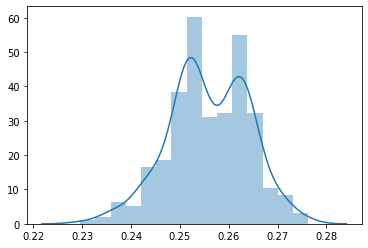

In [113]:
# Print distribution plot of the predictions as well as max and min values. This was used to adjust the multiplier
# mentioned above.
sns.distplot(Final_predictions)
max_BA = round(max(Final_predictions), 3)
min_BA = round(min(Final_predictions), 3)
print("Max predicted BA: ", max_BA)
print("Min predicted BA: ", min_BA)

The values were more heavily regressed to the mean than I had expected and the distribution was not normal. This told me I was undervaluing the March/April stats. To adjust the regression effects, I changed the expected plate appearances to 100 which produced a good normal distribution. Then I pushed the value up slowly until I started to lose that normal distribution. I wanted the value to be as high as possible since 100 plate appearancances weighs the March/April stats very heavily. I settled on a value of 180 which adjusted the range of predicitions to 0.182 to 0.321 (0.139 range) while keeping a normal distribution of predicitions.

To compare to the original constant, Diaz's March/April stats went from having a weight of 6.8% to a weight of 18.8% and Machado's March/April weight increased from 25% to 69.4%.

In [114]:
df_regress = X_top5.copy()
df_regress['MarApr_PA'] = df_data['MarApr_PA'].copy()
df_regress['Multiplier'] = df_regress['MarApr_PA']/180 #Original value was 500
df_regress['OBP'] = df_regress['OBP']*df_regress['Multiplier'] + 0.320*(1-df_regress['Multiplier'])
df_regress['BABIP'] = df_regress['BABIP']*df_regress['Multiplier'] + 0.300*(1-df_regress['Multiplier'])
df_regress['K%'] = df_regress['K%']*df_regress['Multiplier'] + 0.200*(1-df_regress['Multiplier'])
df_regress['BB%'] = df_regress['BB%']*df_regress['Multiplier'] + 0.080*(1-df_regress['Multiplier'])
df_regress['ISO'] = df_regress['ISO']*df_regress['Multiplier'] + 0.140*(1-df_regress['Multiplier'])

Once the weighting constant was adjusted, I reran the model to get my final predicitions.

Max predicted BA:  0.321
Min predicted BA:  0.182


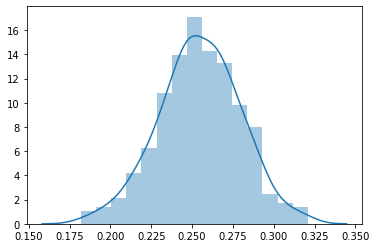

In [115]:
# Copies features of interest from df_regressed
X_regressed = df_regress[['OBP', 'BABIP', 'K%', 'BB%', 'ISO']]

# Makes EoY BA predictions
Final_predictions = clf.predict(X_regressed)

# Print distribution plot of the predictions as well as max and min values. This was used to adjust the multiplier
# mentioned above.
sns.distplot(Final_predictions)
max_BA = round(max(Final_predictions), 3)
min_BA = round(min(Final_predictions), 3)
print("Max predicted BA: ", max_BA)
print("Min predicted BA: ", min_BA)

# Results and Evaluating Model Performance

The final step was to compare the predicitions to the actual full season batting averages. My primary evaluation was MAE which came out to 0.022.

To help visualize my predicitions I plotted the predicted values vs the actual values.

MAE for Full Season BA:  0.022


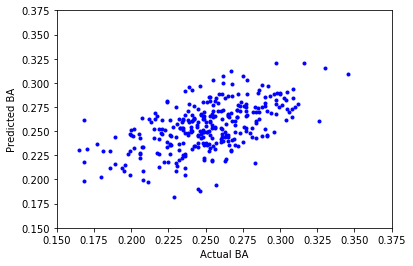

In [118]:
# Evaluate the model using actual EoY averages provided
score = round(mean_absolute_error(df_data['FullSeason_AVG'], Final_predictions), 3)
print("MAE for Full Season BA: ", score)

# Plots the predictions compared to the actual full season batting averages for visualization
plt.figure(2)
plt.plot(df_data['FullSeason_AVG'], Final_predictions, 'b.')
plt.xlabel('Actual BA')
plt.ylabel('Predicted BA')
plt.axis([0.150, 0.375, 0.150, 0.375])
plt.show()

I also wanted to see if the model tended to overestimate or underestimate batting averages. The overestimate/underestimate ratio was 55%/45% indicating the model doesn't have any strong bias in one direction.

In [117]:
pred = Final_predictions
actual = df_data.FullSeason_AVG.copy()
diff = actual - pred

overestimated = len([i for i in diff if i < 0])
underestimated = len([i for i in diff if i > 0])
ratio = round(overestimated/309*100, 2)
print(overestimated, "batting averages were overestimated by the model (", ratio, "%)")
print(underestimated, "batting averages were underestimated by the model (", 100-ratio, "%)")

171 batting averages were overestimated by the model ( 55.34 %)
138 batting averages were underestimated by the model ( 44.66 %)


# Conclusions

The performance of the model wasn't great. The difference of 22 batting average points can be significant over the course of a season. However, Sarah R. Bailey, Jason Loeppky, and Tim B. Swartz did a study comparing Statcast and PECOTA predictions for 2017 batting average that performed similarly. PECOTA's MAE was 0.0236 and Statcast's was 0.0209 (http://people.stat.sfu.ca/~tim/papers/sarah.pdf). Those values indicate this model is performing in the same range as other batting average predicition models.

There are two things I would investigate to improve the model:

1 - Use each player's historical averages for regression instead of league averages. This would work especially well with OBP, K%, BB%, and ISO because they have been shown to have a strong year-to-year correlation which means they stay consistent for each player and therefore we can expect each player to regress to their own averages with more confidence than the league average (https://www.beyondtheboxscore.com/2011/9/1/2393318/what-hitting-metrics-are-consistent-year-to-year). For a stat like BABIP, the year-to-year correlation is much lower, so a league average would be better. This more personalized model would likely give better results, especially for players who have stats significanly different than league averages.

2 - Add additional stats and see if they became top featues and improve final predicitions. The previously mentioned paper by Sarah R. Bailey, Jason Loeppky, and Tim B. Swartz used a Statcast model that considered launch angle and exit velocity. These and other Statcast statistics would be highly insightful.

# Sources

becominghuman.ai (https://becominghuman.ai/understand-regression-performance-metrics-bdb0e7fcc1b3) - using MAE for model performance evaluation

Beyond the Boxscore (https://www.beyondtheboxscore.com/2011/9/1/2393318/what-hitting-metrics-are-consistent-year-to-year) - year-over-year correlation of hitting statistics

Beyond the Boxscore (https://www.beyondtheboxscore.com/2017/12/26/16815098/babip-mlb-batting-average-on-balls-in-play-stats-statcast) - BABIP league average

Fangraphs (https://library.fangraphs.com/offense/rate-stats/) - K% and BB% league averages

Fangraphs (https://library.fangraphs.com/offense/iso/) - ISO league average

Fangraphs (https://library.fangraphs.com/offense/obp/) - OBP league average

Medium (https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d) - choosing MAE for model performance evaluation

The Prediction of Batting Averages in Major League Baseball by Sarah R. Bailey, Jason Loeppky and Tim B. Swartz (http://people.stat.sfu.ca/~tim/papers/sarah.pdf) - using Statcast data to predict batting averages and a comparison for MAE performance

pydata.org (https://seaborn.pydata.org/tutorial/distributions.html) - distribution plot code

Towards Data Science (https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e) - tuning a XGBoost model